# String Calculations for String Sound Article

70
35
./harp_stress.png


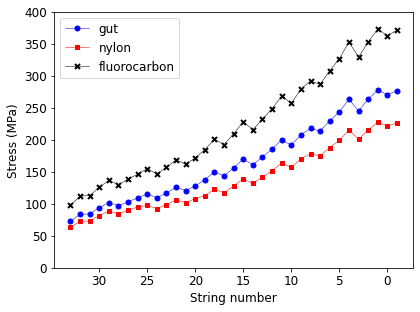

./harp_diameter.png


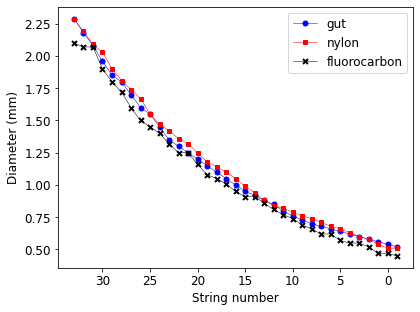

./harp_tension.png


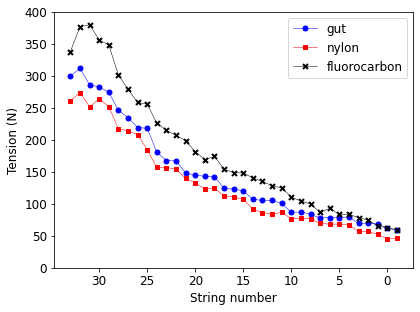

./harp_impedance.png


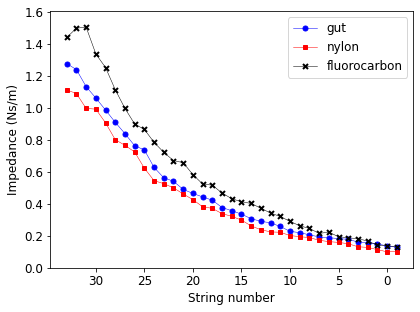

./harp_feel.png


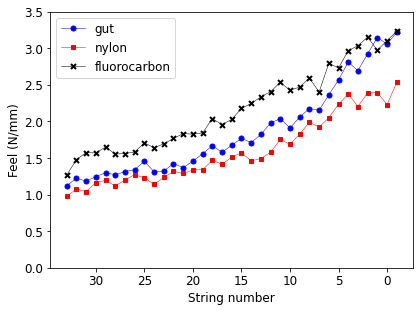

./harp_Eb.png


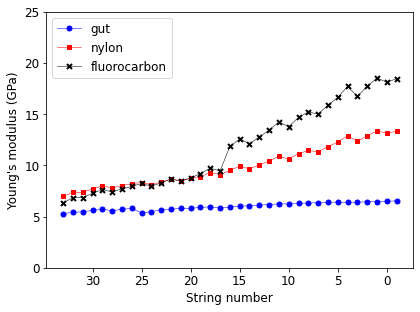

./harp_inharmonicity.png


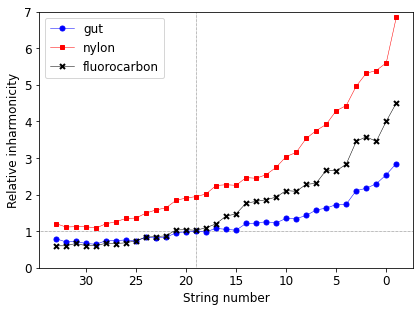

./harp_overtones.png


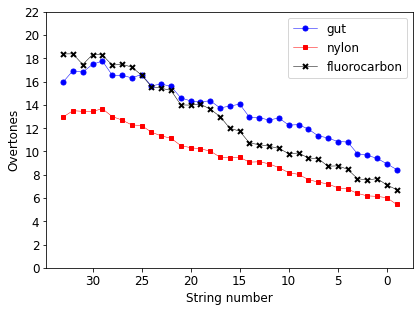

./harp_bandwidth.png


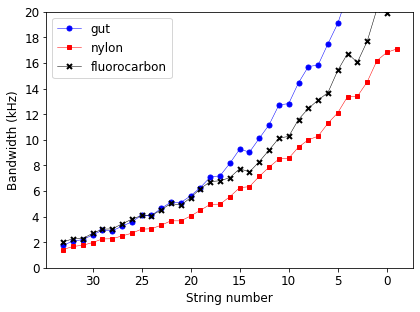

./harp_AE.png


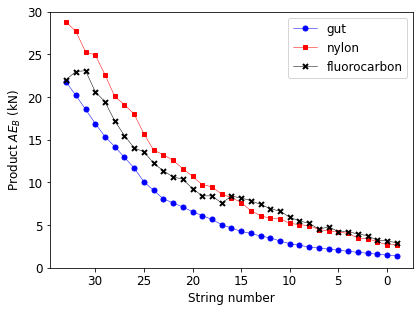

In [6]:
# References:
# 1: "Choosing Strings for Plucked Musical Instruments"  https://doi.org/10.3813/AAA.919333
# 2: "Mechanical Properties of Nylon Harp Strings"  https://doi.org/10.3390/ma10050497
# 3: "Comparison of Mechanical Properties of Natural Gut and Synthetic Polymer Harp Strings" 
#     https://doi.org/10.3390/ma11112160

import numpy as np
import matplotlib.pyplot as plt
# enable plots to be shown in cells
%matplotlib inline

plt.rcParams.update({'font.size': 12})

lamda_threshold = 0.05              # lambda threshold value for damping constraint
default_overtones = 10              # number of overtones for damping constraint

save_plots = False

fig_size = (6,4.5)
save_format = 'png' # 'eps'
save_path = './'

def calc_tension(frequency, length, diameter, rho): # Hz, m, mm, kg/m^3
    two_fL = 2 * frequency * length
    stress = two_fL**2 * rho / 1e6              # MPa
    tension = stress * np.pi * diameter**2 / 4  # N
    feel = 4 * tension / length                 # N/m - reference 1, eq.(10)
    impedance = np.pi * diameter**2 * rho * length * frequency / 2e6  # Ns/m - reference 1, eq.(8)
    return stress, tension, feel, impedance

def calc_bending(length, diameter, tension, Eb): # m, mm, N, GPa
    bend_stiff = Eb * np.pi * diameter**4 / 64000  # Eb in GPa, diameter in mm - reference 2, eq.(18)
    inharmonicity = bend_stiff * np.pi * np.pi / (2 * tension * length**2)  # reference 2, eq.(17)
    return bend_stiff, inharmonicity

def calc_overtones(lamda_threshold, frequency, length, diameter, rho, Eb): # no unit, Hz, m, mm, kg/m^3, GPa
    # see reference 1 for theoretical background
    lambda_adj = lamda_threshold / (1.0 - lamda_threshold)  # allows reference 1, eq.(7) to be used in place of eq.(4)
    overtones = 8000.0 * length**2 * frequency * np.sqrt(lambda_adj * rho / (Eb * 1e9)) / (np.pi * diameter)  # ref.1, eq.(7)
    bandwidth = overtones * frequency
    return overtones, bandwidth

# material properties
# gut
rho_g = 1320.0          # density, kg/m^3 - reference 3 (and associated data files)
# nylon
rho_n_lo = 1080.0       # density, kg/m^3 - reference 2 (and associated data files)
rho_n_hi = 1150.0       # density, kg/m^3 - reference 2 (and associated data files)
rho_n_avg = (rho_n_lo + rho_n_hi) / 2
E0_n = 4.52905496       # E' fixed part (GPa) - reference 2, Appendix A
E1_n = 0.03887992       # E' stress part (for stress in MPa)
# fluorocarbon
rho_c = 1770.0     # density, kg/m^3
E0_c_lo  = 3.24746902   # low diameter, E' fixed part (GPa) - reference 3 (and associated data analysis) 
E1_c_lo  = 0.04100955   # low diameter, E' stress part (for stress in MPa)
E0_c_hi  = 3.18497582   # high diameter, E' fixed part (GPa) - reference 3 (and associated data analysis)
E1_c_hi  = 0.03259183   # high diameter, E' stress part (for stress in MPa)
txn_c = 0.98            # diameter marking transition between wound and unwound construction

# Load Young's modulus estimates for gut strings
#filename = "./Youngs modulus estimates v1.csv"  # for version 1 plots
filename = "./Youngs modulus estimates v2.csv"  # for version 2 plots
with open(filename, "r") as data_file:
    data = data_file.readlines()
data_array = []
for line in data[4:]:  # skip header rows
    data_array.append(line.split(','))
d_count = len(data_array)
print(d_count)
diameter_g_ref =  np.array([data_array[i][0] for i in range(d_count)], dtype=float)         # values in mm
Eb_g_ref =        np.array([data_array[i][1] for i in range(d_count)], dtype=float)         # values in GPa
diameter_g_ref[0] = 0.0                              # adjust min and max reference diameters to avoid array overruns
diameter_g_ref = np.append(diameter_g_ref,[np.inf])  # but note that negative diameter values will still throw errors

# Read in harp string data
filename = "./string gauge charts.csv"
with open(filename, "r") as data_file:
    data = data_file.readlines()
data_array = []
for line in data[4:]:  # skip header rows
    data_array.append(line.split(','))
d_count = len(data_array)
print(d_count)
str_freq =    np.array([data_array[i][2] for i in range(d_count)], dtype=float)         # values in Hz
str_length =  np.array([data_array[i][3] for i in range(d_count)], dtype=float) / 1000  # values in mm, converted to m
diameter_g =  np.array([data_array[i][4] for i in range(d_count)], dtype=float)         # values in mm
diameter_n =  np.array([data_array[i][5] for i in range(d_count)], dtype=float)         # values in mm
diameter_c =  np.array([data_array[i][6] for i in range(d_count)], dtype=float)         # values in mm


# gut calculations
# stress, tension, feel, impedance
stress_g, tension_g, feel_g, impedance_g = calc_tension(str_freq, str_length, diameter_g, rho_g)
# Young's modulus Eb (GPa)
#  where the diameter is between two reference values, select the Young's modulus for the lower diameter
Eb_g = np.array([Eb_g_ref[np.argmin(diameter_g_ref <= diameter_g[i])-1] for i in range(len(diameter_g))])
# bending stiffness and inharmonicity factor c/a
bend_stiff_g, inharmonicity_g = calc_bending(str_length, diameter_g, tension_g, Eb_g)
inharmonicity_ref = inharmonicity_g[20]  # string 19, 3rd octave A, A4, 440 Hz
# overtones, bandidth
overtones_g, bandwidth_g = calc_overtones(lamda_threshold, str_freq, str_length, diameter_g, rho_g, Eb_g)
# product A.Eb
AE_g = 1000* np.pi * diameter_g**2 * Eb_g / 4  # N

# nylon calculations
# density
rho_n = np.ones_like(diameter_n)
for i in range(len(diameter_n)):
    rho_n[i] = rho_n_hi if (diameter_n[i] >= 1.67) else rho_n_avg if (diameter_n[i] > 1.18) else rho_n_lo
# stress, tension, feel, impedance
stress_n, tension_n, feel_n, impedance_n = calc_tension(str_freq, str_length, diameter_n, rho_n)
# Young's modulus Eb (GPa)
Eb_n = E0_n + E1_n * stress_n
# bending stiffness and inharmonicity factor c/a
bend_stiff_n, inharmonicity_n = calc_bending(str_length, diameter_n, tension_n, Eb_n)
# overtones, bandidth
overtones_n, bandwidth_n = calc_overtones(lamda_threshold, str_freq, str_length, diameter_n, rho_n, Eb_n)
# product A.Eb
AE_n = 1000* np.pi * diameter_n**2 * Eb_n / 4  # N

# fluorocarbon standard calculations
# stress, tension, feel, impedance
stress_c, tension_c, feel_c, impedance_c = calc_tension(str_freq, str_length, diameter_c, rho_c)
# Young's modulus Eb (GPa)
Eb_c = np.zeros_like(diameter_c)
for i in range(len(diameter_c)):
    Eb_c[i] = E0_c_lo + E1_c_lo * stress_c[i] if (diameter_c[i] <= txn_c) else E0_c_hi + E1_c_hi * stress_c[i]
# bending stiffness and inharmonicity factor c/a
bend_stiff_c, inharmonicity_c = calc_bending(str_length, diameter_c, tension_c, Eb_c)
# overtones, bandidth
overtones_c, bandwidth_c = calc_overtones(lamda_threshold, str_freq, str_length, diameter_c, rho_c, Eb_c)
# product A.Eb
AE_c = 1000* np.pi * diameter_c**2 * Eb_c / 4  # N


# plots
x_range = np.arange(-1, 34, 1)

# stress
fig=plt.figure(figsize=fig_size)
ax1=fig.add_subplot(111)
ax1.plot(x_range, stress_g, 'b-o', lw=0.5, ms=5, label='gut')
ax1.plot(x_range, stress_n, 'r-s', lw=0.5, ms=4, label='nylon')
ax1.plot(x_range, stress_c, 'k-x', lw=0.5, ms=5, mew=2, label='fluorocarbon')
ax1.axis([-2.7,34.7,0,400])
ax1.invert_xaxis()
ax1.set_xlabel('String number')
ax1.set_ylabel('Stress (MPa)')
ax1.legend()
plt.tight_layout()  
save_file = save_path + 'harp_stress.' + save_format
print(save_file)
if(save_plots):
    plt.savefig(save_file, format=save_format, dpi=1000)
plt.show()

# diameter
fig=plt.figure(figsize=fig_size)
ax1=fig.add_subplot(111)
ax1.plot(x_range, diameter_g, 'b-o', lw=0.5, ms=5, label='gut')
ax1.plot(x_range, diameter_n, 'r-s', lw=0.5, ms=4, label='nylon')
ax1.plot(x_range, diameter_c, 'k-x', lw=0.5, ms=5, mew=2, label='fluorocarbon')
ax1.invert_xaxis()
ax1.set_xlabel('String number')
ax1.set_ylabel('Diameter (mm)')
ax1.legend()
plt.tight_layout()  
save_file = save_path + 'harp_diameter.' + save_format
print(save_file)
if(save_plots):
    plt.savefig(save_file, format=save_format, dpi=1000)
plt.show()

# tension
fig=plt.figure(figsize=fig_size)
ax1=fig.add_subplot(111)
ax1.plot(x_range, tension_g, 'b-o', lw=0.5, ms=5, label='gut')
ax1.plot(x_range, tension_n, 'r-s', lw=0.5, ms=4, label='nylon')
ax1.plot(x_range, tension_c, 'k-x', lw=0.5, ms=5, mew=2, label='fluorocarbon')
ax1.axis([-2.7,34.7,0,400])
ax1.invert_xaxis()
ax1.set_xlabel('String number')
ax1.set_ylabel('Tension (N)')
ax1.legend()
plt.tight_layout()  
save_file = save_path + 'harp_tension.' + save_format
print(save_file)
if(save_plots):
    plt.savefig(save_file, format=save_format, dpi=1000)
plt.show()

# impedance
fig=plt.figure(figsize=fig_size)
ax1=fig.add_subplot(111)
ax1.plot(x_range, impedance_g, 'b-o', lw=0.5, ms=5, label='gut')
ax1.plot(x_range, impedance_n, 'r-s', lw=0.5, ms=4, label='nylon')
ax1.plot(x_range, impedance_c, 'k-x', lw=0.5, ms=5, mew=2, label='fluorocarbon')
ax1.axis([-2.7,34.7,0,max(impedance_c)+0.1])
ax1.invert_xaxis()
ax1.set_xlabel('String number')
ax1.set_ylabel('Impedance (Ns/m)')
ax1.legend()
plt.tight_layout()  
save_file = save_path + 'harp_impedance.' + save_format
print(save_file)
if(save_plots):
    plt.savefig(save_file, format=save_format, dpi=1000)
plt.show()

# feel
fig=plt.figure(figsize=fig_size)
ax1=fig.add_subplot(111)
ax1.plot(x_range, feel_g/1000, 'b-o', lw=0.5, ms=5, label='gut')
ax1.plot(x_range, feel_n/1000, 'r-s', lw=0.5, ms=4, label='nylon')
ax1.plot(x_range, feel_c/1000, 'k-x', lw=0.5, ms=5, mew=2, label='fluorocarbon')
ax1.axis([-2.7,34.7,0,3.5])
ax1.invert_xaxis()
ax1.set_xlabel('String number')
ax1.set_ylabel('Feel (N/mm)')
ax1.legend()
plt.tight_layout()  
save_file = save_path + 'harp_feel.' + save_format
print(save_file)
if(save_plots):
    plt.savefig(save_file, format=save_format, dpi=1000)
plt.show()

# Young's modulus
fig=plt.figure(figsize=fig_size)
ax1=fig.add_subplot(111)
ax1.plot(x_range, Eb_g, 'b-o', lw=0.5, ms=5, label='gut')
ax1.plot(x_range, Eb_n, 'r-s', lw=0.5, ms=4, label='nylon')
ax1.plot(x_range, Eb_c, 'k-x', lw=0.5, ms=5, mew=2, label='fluorocarbon')
ax1.axis([-2.7,34.7,0,25])
ax1.invert_xaxis()
ax1.set_xlabel('String number')
ax1.set_ylabel("Young's modulus (GPa)")
ax1.legend(loc='upper left')
plt.tight_layout()  
save_file = save_path + 'harp_Eb.' + save_format
print(save_file)
if(save_plots):
    plt.savefig(save_file, format=save_format, dpi=1000)
plt.show()

# inharmonicity
fig=plt.figure(figsize=fig_size)
ax1=fig.add_subplot(111)
ax1.plot([-3,35],[1,1],'k:',lw=0.5)
ax1.plot([19,19],[0,7],'k:',lw=0.5)
ax1.plot(x_range, inharmonicity_g/inharmonicity_ref, 'b-o', lw=0.5, ms=5, label='gut')
ax1.plot(x_range, inharmonicity_n/inharmonicity_ref, 'r-s', lw=0.5, ms=4, label='nylon')
ax1.plot(x_range, inharmonicity_c/inharmonicity_ref, 'k-x', lw=0.5, ms=5, mew=2, label='fluorocarbon')
ax1.axis([-2.7,34.7,0,7])
ax1.invert_xaxis()
ax1.set_xlabel('String number')
ax1.set_ylabel("Relative inharmonicity")
ax1.legend(loc='upper left')
plt.tight_layout()  
save_file = save_path + 'harp_inharmonicity.' + save_format
print(save_file)
if(save_plots):
    plt.savefig(save_file, format=save_format, dpi=1000)
plt.show()

# overtones
fig=plt.figure(figsize=fig_size)
ax1=fig.add_subplot(111)
ax1.plot(x_range, overtones_g, 'b-o', lw=0.5, ms=5, label='gut')
ax1.plot(x_range, overtones_n, 'r-s', lw=0.5, ms=4, label='nylon')
ax1.plot(x_range, overtones_c, 'k-x', lw=0.5, ms=5, mew=2, label='fluorocarbon')
ax1.axis([-2.7,34.7,0,22])
ax1.invert_xaxis()
ax1.set_yticks(np.arange(0, 23, 2))
ax1.set_xlabel('String number')
ax1.set_ylabel('Overtones')
ax1.legend()
plt.tight_layout()  
save_file = save_path + 'harp_overtones.' + save_format
print(save_file)
if(save_plots):
    plt.savefig(save_file, format=save_format, dpi=1000)
plt.show()

# bandwidth
fig=plt.figure(figsize=fig_size)
ax1=fig.add_subplot(111)
ax1.plot(x_range, bandwidth_g/1000, 'b-o', lw=0.5, ms=5, label='gut')
ax1.plot(x_range, bandwidth_n/1000, 'r-s', lw=0.5, ms=4, label='nylon')
ax1.plot(x_range, bandwidth_c/1000, 'k-x', lw=0.5, ms=5, mew=2, label='fluorocarbon')
ax1.axis([-2.7,34.7,0,20])
ax1.invert_xaxis()
ax1.set_yticks(np.arange(0, 21, 2))
ax1.set_xlabel('String number')
ax1.set_ylabel('Bandwidth (kHz)')
ax1.legend()
plt.tight_layout()  
save_file = save_path + 'harp_bandwidth.' + save_format
print(save_file)
if(save_plots):
    plt.savefig(save_file, format=save_format, dpi=1000)
plt.show()

# product AE
fig=plt.figure(figsize=fig_size)
ax1=fig.add_subplot(111)
ax1.plot(x_range, AE_g/1000, 'b-o', lw=0.5, ms=5, label='gut')
ax1.plot(x_range, AE_n/1000, 'r-s', lw=0.5, ms=4, label='nylon')
ax1.plot(x_range, AE_c/1000, 'k-x', lw=0.5, ms=5, mew=2, label='fluorocarbon')
ax1.axis([-2.7,34.7,0,30])
ax1.invert_xaxis()
ax1.set_xlabel('String number')
ax1.set_ylabel('Product $AE_B$ (kN)')
ax1.legend()
plt.tight_layout()  
save_file = save_path + 'harp_AE.' + save_format
print(save_file)
if(save_plots):
    plt.savefig(save_file, format=save_format, dpi=1000)
plt.show()


